<a href="https://colab.research.google.com/github/KaterynaZakharova/Olive-Separation-With-TensorFlow-Object-Detection-API/blob/main/Olive_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installation**

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/')

In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
import sys
sys.path.append('content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/slim')

In [ ]:
!pip install tf_slim

     |████████████████████████████████| 358kB 2.8MB/s 


In [ ]:
!pip install pycocotools

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research

/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research


In [ ]:
!pip install .

Processing /content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1390904 sha256=1d257dea41656607ce4fa7fe182d24df23a87f5bbf89a897a14e6b685866e548
  Stored in directory: /tmp/pip-ephem-wheel-cache-evz81_xv/wheels/65/69/54/5c1683fdbb547b53afa0b28d8f3842b649c02d9c05b2bc2a34
Successfully built object-detection


In [ ]:
import os
os.environ['PYTHONPATH'] += '/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/:/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/slim/'

In [ ]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/MyDrive/Colab Notebooks/Olive Separation/models"

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/Olive Separation/models")

In [ ]:
!pip install lvis

**Train**

In [23]:
%cd /content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/object_detection

/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/object_detection


In [ ]:
# !python model_main_tf2.py \
#     --pipeline_config_path=training/ssd_efficientdet_d0_512x512_coco17_tpu-8.config \
#     --model_dir=training \
#     --alsologtostderr

In [ ]:
!python model_main_tf2.py \
    --pipeline_config_path=training/centernet_hg104_512x512_coco17_tpu-8.config \
    --model_dir=training \
    --alsologtostderr

**Inference graph**

In [ ]:
#!python exporter_main_v2.py --trained_checkpoint_dir=training/ --pipeline_config_path=training/ssd_efficientdet_d0_512x512_coco17_tpu-8.config --output_directory inference_graph

In [ ]:
!python exporter_main_v2.py --trained_checkpoint_dir=training/ --pipeline_config_path=training/centernet_hg104_512x512_coco17_tpu-8.config --output_directory inference_graph

**Test**

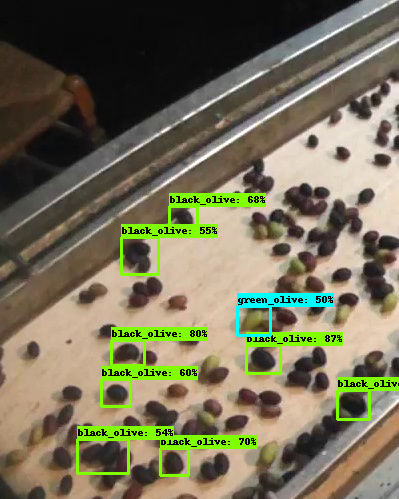

8 black olives
1 green olives


In [24]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

def image_to_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

category_index = label_map_util.create_category_index_from_labelmap('/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/object_detection/training/labelmap.pbtxt', use_display_name=True)

tf.keras.backend.clear_session()
model = tf.saved_model.load('/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/object_detection/inference_graph/saved_model/')

def inference_for_image(model, image):
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
  return output_dict

count_black = 0
count_green = 0

for image_path in glob.glob('*.jpg'):
  image_np = image_to_array(image_path)
  output_dict = inference_for_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=3)
  display(Image.fromarray(image_np))
  for i in range(100):
    if output_dict['detection_scores'][i] > 0.5:
      if output_dict['detection_classes'][i] == 1:
        count_black = count_black + 1
      if output_dict['detection_classes'][i] == 2:
        count_green = count_green + 1

print(count_black, 'black olives')
print(count_green, 'green olives')

-----------------------------------------------------------------------------

Variant 2

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [ ]:
train_image_dir = '/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/object_detection/images/train/'
train_images_np = []
for i in range(1, 25):
  if i not in (3, 10, 11, 16, 18):
    image_path = os.path.join(train_image_dir, 'black_olive_' + str(i) + '.jpg')
    train_images_np.append(load_image_into_numpy_array(image_path))

# plt.rcParams['axes.grid'] = False
# plt.rcParams['xtick.labelsize'] = False
# plt.rcParams['ytick.labelsize'] = False
# plt.rcParams['xtick.top'] = False
# plt.rcParams['xtick.bottom'] = False
# plt.rcParams['ytick.left'] = False
# plt.rcParams['ytick.right'] = False
# plt.rcParams['figure.figsize'] = [14, 7]

# for idx, train_image_np in enumerate(train_images_np):
#   plt.subplot(2, 3, idx+1)
#   plt.imshow(train_image_np)
# plt.show()

In [ ]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

[]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
black_olive_class_id = 1
num_classes = 1
category_index = {black_olive_class_id: {'id': black_olive_class_id, 'name': 'black_olive'}}

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

[array([[0.59666667, 0.39666667, 0.67      , 0.55      ]]), array([[0.49666667, 0.43666667, 0.58      , 0.54333333]]), array([[0.54333333, 0.39      , 0.695     , 0.57666667]]), array([[0.47166667, 0.41666667, 0.53333333, 0.52666667]]), array([[0.395     , 0.42666667, 0.50666667, 0.52666667]]), array([[0.71666667, 0.73333333, 0.80166667, 0.86      ]]), array([[0.63166667, 0.47333333, 0.69166667, 0.58      ]]), array([[0.41333333, 0.23666667, 0.49833333, 0.32333333]]), array([[0.64833333, 0.42333333, 0.69666667, 0.5       ]]), array([[0.635     , 0.51666667, 0.68833333, 0.59333333]]), array([[0.47666667, 0.49      , 0.52833333, 0.57      ]]), array([[0.48666667, 0.51      , 0.54666667, 0.61666667],
       [0.56833333, 0.50333333, 0.56833333, 0.50333333]]), array([[0.52333333, 0.38      , 0.62333333, 0.54333333]]), array([[0.485     , 0.45      , 0.58333333, 0.59333333]]), array([[0.55166667, 0.44333333, 0.66166667, 0.60666667]]), array([[0.44333333, 0.36      , 0.56333333, 0.56333333]])

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30, 15))
# for idx in range(20):
#   plt.subplot(4, 5, idx+1)
#   plot_detections(
#       train_images_np[idx],
#       gt_boxes[idx],
#       np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
#       dummy_scores, category_index)
# plt.show()

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint '/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/object_detection/test_data/'

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = '/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/object_detection/test_data/checkpoint/ckpt-0'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.01
num_batches = 100

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

In [ ]:
test_image_dir = '/content/drive/MyDrive/Colab Notebooks/Olive Separation/models/research/object_detection/images/test/'
test_images_np = []
for i in (3, 10, 11, 16, 18):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")